In [1]:
from Bio import SeqIO
import pandas as pd
import re
from Levenshtein import distance
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Functions:

# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    fasta_seqs = SeqIO.parse(open('inputs/' + name + '.fasta.txt'),'fasta')
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    
    return data


# write FASTA file:
# input: file name; df to write
def write_fasta(name, seqs_df):
    out_file = open('outputs/' + name + '.fasta.txt', "w")
    for i in range(len(seqs_df)):
        out_file.write('>' + seqs_df.name[i] + '\n')
        out_file.write(seqs_df.sequence[i] + '\n')
    out_file.close()


# input: takes in a sequence
# output: True if a sequence contains only standard amino acids, returns False if contains non-standard ones.
def validate(seq, pattern=re.compile(r'^[FIWLVMYCATHGSQRKNEPD]+$')):
    if (pattern.match(seq)):
        return True
    return False

    
# Remove sequences longer than k residues and with non-standard residues
# inputs: seqs_df = dataframe of name, sequence; k = max lenght of residues to keep
# output: cleaned dataframe
def clean(seqs_df, k):
    # remove sequences with length > 1000 AA's
    rows2drop = []
    for i in range(len(seqs_df)):
        if (len(seqs_df.sequence[i]) > k):
            rows2drop.append(i)

    print('Total number of sequences dropped:', len(rows2drop))

    seqs_df = seqs_df.drop(rows2drop).reset_index().drop('index', axis=1)

    print('Total number of sequences remaining:', len(seqs_df))
    
    # remove sequences with invalid AA residues
    # valid_alphabet = ['F','I','W','L','V','M','Y','C','A','T','H','G','S','Q','R','K','N','E','P','D']
    invalid_seqs = []

    for i in range(len(seqs_df)):
        if (not validate(seqs_df.sequence[i])):
            invalid_seqs.append(i)

    print('Total number of sequences dropped:', len(invalid_seqs))

    seqs_df = seqs_df.drop(invalid_seqs).reset_index().drop('index', axis=1)

    print('Total number of sequences remaining:', len(seqs_df))
    
    
    seqs_df = seqs_df.drop_duplicates(subset='sequence').reset_index().drop('index', axis=1)

    print('Total sequences remaining after duplicate removal', len(seqs_df))

    
    return seqs_df


# calculate the Levenstein distance of mulitple sequences to a target sequence
# also plots a histogram of distances
# inputs: t_seq = target sequence; seqs_df = dataframe of sequences;
# num_bins = bins for histogram; hist_range = range for histogram
# outputs: numpy array of distances
def lev_dist(t_seq, seqs_df, num_bins=20, hist_range=(0,350)):
    distances = []
    for i in range(len(seqs_df)):
        distances.append(distance(t_seq, seqs_df.sequence[i]))
    distances = np.array(distances)

    mean_dist = np.mean(distances)

    print("Mean Levenstein distance:", mean_dist)
    
    # histogram of Levenstein distances from target sequence
    plt.clf()
    plt.hist(distances, bins=num_bins, range=hist_range)
    plt.show()
    
    return distances

# get the minimum N:M values (i.e. for top 100 N = 0, M = 100) from an array of numbers.
# inputs: scores = values to sort by; seqs_df = dataframe of sequences; N = start index; M = end index
# output: returns 2 arrays: 1st the sequences with highest scores in the specified range;
# 2nd the corresponding keys (i.e. seq names)
def get_batch(scores, seqs_df, N, M):
    idx = np.argpartition(scores, M)

    batch_N2M = []
    batch_N2M_names = []
    for_df = []
    for i in range(N,M):
        batch_N2M.append(seqs_df.sequence[idx[i]])
        batch_N2M_names.append(seqs_df.name[idx[i]])
        for_df.append([seqs_df.name[idx[i]], seqs_df.sequence[idx[i]]])
    
    df = pd.DataFrame(for_df, columns = ['name', 'sequence'])
    
    return batch_N2M, batch_N2M_names, df

# write FASTA file:
# input: file name; df to write; wild type name and sequence to write
def write_fasta4jackHMMer(wt_name, wt_seq, batch_name, seqs_df):
    out_file = open('outputs/' + wt_name + '_' + batch_name + '.fasta.txt', "w")
    out_file.write('>' + wt_name + '\n')
    out_file.write(wt_seq + '\n')
    for i in range(len(seqs_df)):
        out_file.write('>' + seqs_df.name[i] + '\n')
        out_file.write(seqs_df.sequence[i] + '\n')
    out_file.close()
    


"""
File formatting note.
Data should be preprocessed as a sequence of comma-seperated ints with
sequences  /n seperated
"""

# Lookup tables
aa_to_int = {
    'M':1,
    'R':2,
    'H':3,
    'K':4,
    'D':5,
    'E':6,
    'S':7,
    'T':8,
    'N':9,
    'Q':10,
    'C':11,
    'U':12,
    'G':13,
    'P':14,
    'A':15,
    'V':16,
    'I':17,
    'F':18,
    'Y':19,
    'W':20,
    'L':21,
    'O':22, #Pyrrolysine
    'X':23, # Unknown
    'Z':23, # Glutamic acid or GLutamine
    'B':23, # Asparagine or aspartic acid
    'J':23, # Leucine or isoleucine
    'start':24,
    'stop':25,
}

int_to_aa = {value:key for key, value in aa_to_int.items()}

def get_aa_to_int():
    """
    Get the lookup table (for easy import)
    """
    return aa_to_int

def get_int_to_aa():
    """
    Get the lookup table (for easy import)
    """
    return int_to_aa
    
def aa_seq_to_int(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return [24] + [aa_to_int[a] for a in s] + [25]

def int_seq_to_aa(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return "".join([int_to_aa[i] for i in s])

    
def format_seq(seq,stop=False):
    """
    Takes an amino acid sequence, returns a list of integers in the codex of the babbler.
    Here, the default is to strip the stop symbol (stop=False) which would have 
    otherwise been added to the end of the sequence. If you are trying to generate
    a rep, do not include the stop. It is probably best to ignore the stop if you are
    co-tuning the babbler and a top model as well.
    """
    if stop:
        int_seq = aa_seq_to_int(seq.strip())
    else:
        int_seq = aa_seq_to_int(seq.strip())[:-1]
    return int_seq

def is_valid_seq(seq, max_len=2000):
    """
    True if seq is valid for the babbler, False otherwise.
    """
    l = len(seq)
    valid_aas = "MRHKDESTNQCUGPAVIFYWLO"
    if (l < max_len) and set(seq) <= set(valid_aas):
        return True
    else:
        return False

def fasta_to_input(in_path):
    source = SeqIO.parse(in_path + '.fasta.txt','fasta')
    with open(in_path + "_formatted.fasta.txt", "w") as destination:
        for seq in fasta_seqs:
            seq = seq.strip()
            if is_valid_seq(seq) and len(seq) < 275: 
                formatted = ",".join(map(str,format_seq(seq)))
                destination.write(formatted)
                destination.write('\n')

def seqs_to_input(name, in_seqs, stop=False):
    with open(name + "_formatted.fasta.txt", "w") as destination:
        for seq in in_seqs:
            seq = seq.strip()
            if is_valid_seq(seq): 
                formatted = ",".join(map(str,format_seq(seq, stop=stop)))
                destination.write(formatted)
                destination.write('\n')


In [8]:
# input FASTA file:
in_fasta = 'dlh'

# put sequences into a pandas dataframe
sequences_df = pd.DataFrame(read_fasta(in_fasta), columns = ['name', 'sequence'])

print('Total number of input sequences:', len(sequences_df))

# clean the sequences:
clean_seqs_df = clean(sequences_df, 300)

# save clean sequences as a .fasta.txt file
write_fasta('clean_' + in_fasta, clean_seqs_df)

Total number of input sequences: 70110
Total number of sequences dropped: 12148
Total number of sequences remaining: 57962
Total number of sequences dropped: 637
Total number of sequences remaining: 57325
Total sequences remaining after duplicate removal 51397


In [9]:
# load target sequence
target_fasta = 'duraPETase'
targets = read_fasta(target_fasta)
print(targets[0][0])
print(targets[0][1])

duraPETase
MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEASAGPFTVRSFTVSRPSGYGAGTVYYPTNAGGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTFDYPSSRSSQQMAALRQVASLNGDSSSPIYGKVDTARMGVMGHSMGGGASLRSAANNPSLKAAIPQAPWDSQTNFSSVTVPTLIFACENDSIAPVNSHALPIYDSMSRNAKQFLEINGGSHSCANSGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTAVSDFRTANCS


Mean Levenstein distance: 229.59592972352473


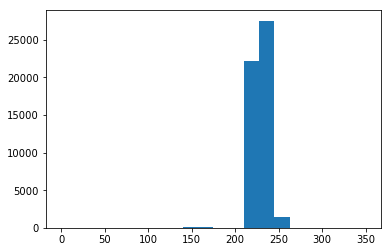

In [10]:
# calculate levenstein distance from chosen target sequence
distances = lev_dist(targets[0][1], clean_seqs_df)

Mean Levenstein distance: 153.41


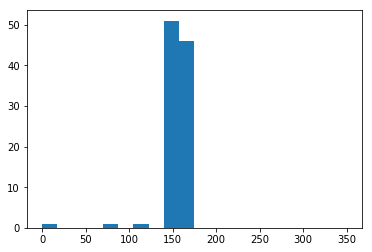

In [11]:
# load wild-type sequence
WT_fasta = 'isPETase'
WT_seq = read_fasta(WT_fasta)[0][1]


# get the top 100 scores.

closest_100, closest_100_names, closest_100_df = get_batch(distances, clean_seqs_df, 0, 100)

# verify they are indeed the top 100 scores.
closest_100_dists = lev_dist(targets[0][1], closest_100_df)

# save closest 100 sequences to target as a .fasta.txt file
write_fasta('closest_100_to_' + target_fasta, closest_100_df)

# save output for jackHMMer search (top 100 with target appended!) 
write_fasta4jackHMMer(WT_fasta, WT_seq, 'top_100', closest_100_df)

Mean Levenstein distance: 173.72


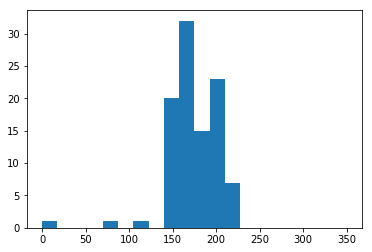

Mean Levenstein distance: 213.75


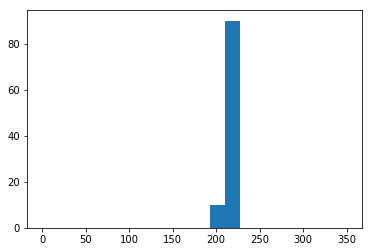

Mean Levenstein distance: 215.29


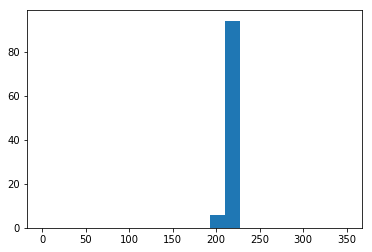

Mean Levenstein distance: 205.22


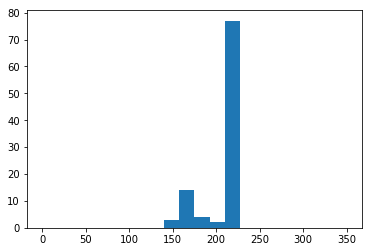

Mean Levenstein distance: 217.3


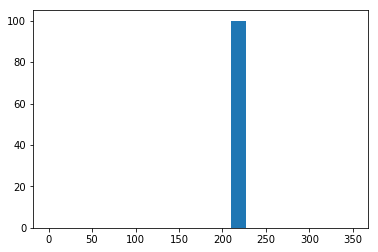

Mean Levenstein distance: 217.86


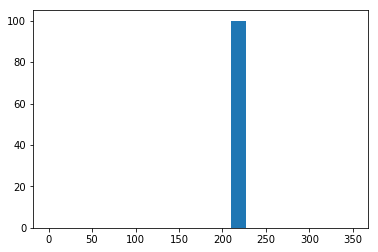

Mean Levenstein distance: 214.81


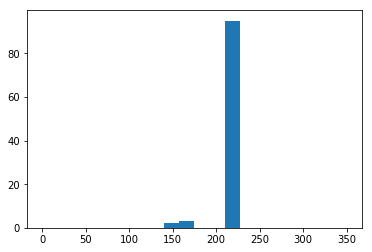

Mean Levenstein distance: 218.0


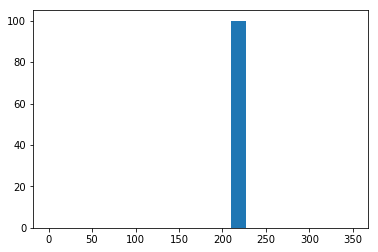

Mean Levenstein distance: 218.59


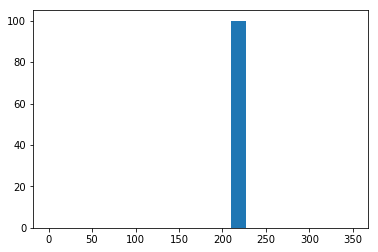

In [12]:
# get scores 100-200.

batches_to_run = [100, 200, 300, 400, 500, 600, 700, 800, 900]

for b in batches_to_run:
    this_b, this_b_names, this_b_df = get_batch(distances, clean_seqs_df, b, (b+100))

    # verify they are indeed the top 100 scores.
    this_b_dists = lev_dist(targets[0][1], this_b_df)

    # save output for jackHMMer search (top 100 with target appended!) 
    write_fasta4jackHMMer(WT_fasta, WT_seq, str(b), this_b_df)

# Ran files on HMMer

In [10]:
# input FASTA file:
jackhmmer_hits = 'isPETase_jackHMMer_hits'

# put sequences into a pandas dataframe
jackhmmer_df = pd.DataFrame(read_fasta(jackhmmer_hits), columns = ['name', 'sequence'])

print('Total number of input sequences:', len(jackhmmer_df))

# clean the sequences:
clean_jackhmmer_df = clean(jackhmmer_df, 600)
write_fasta('clean_' + jackhmmer_hits, clean_jackhmmer_df)

Total number of input sequences: 2562
Total number of sequences dropped: 487
Total number of sequences remaining: 2075
Total number of sequences dropped: 2
Total number of sequences remaining: 2073
Total sequences remaining after duplicate removal 1842


### Conclusion: Spent way too long trying to get jackHMMer to work. Whats the point? Our starting PFAM results already had so many sequences with low edit distance... lets just use those.

In [13]:
# partition into the training and 2 validation sets:

clean_seqs_df_copy = clean_seqs_df.copy()
out_domain_val_set = clean_seqs_df_copy.sample(frac=0.1, weights=distances**4, random_state=17)
remainder_df = clean_seqs_df_copy.drop(out_domain_val_set.index)
train_set = remainder_df.sample(frac=0.889, random_state=17)
in_domain_val_set = remainder_df.drop(train_set.index)


In [14]:
# set check sizes
print('Out of domain validation set size:', len(out_domain_val_set))
print('In domain validation set size:', len(in_domain_val_set))
print('Training set size:', len(train_set))

Out of domain validation set size: 5140
In domain validation set size: 5135
Training set size: 41122


In [15]:
# save to fasta file formats:

write_fasta('train_set', train_set.reset_index().drop('index', axis=1))
write_fasta('out_domain_val_set', out_domain_val_set.reset_index().drop('index', axis=1))
write_fasta('in_domain_val_set', in_domain_val_set.reset_index().drop('index', axis=1))


# Make input sequences for UniRep

In [16]:
seqs_to_input('train_set', train_set.sequence, stop=True)
seqs_to_input('out_domain_val_set', out_domain_val_set.sequence, stop=True)
seqs_to_input('in_domain_val_set', in_domain_val_set.sequence, stop=True)